/var/folders/xd/rvp2n9dd0c50dlfd6dhp7m9m0000gn/T/ipykernel_20133/1304440340.py:22: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  temp = temp.stack(level=0)


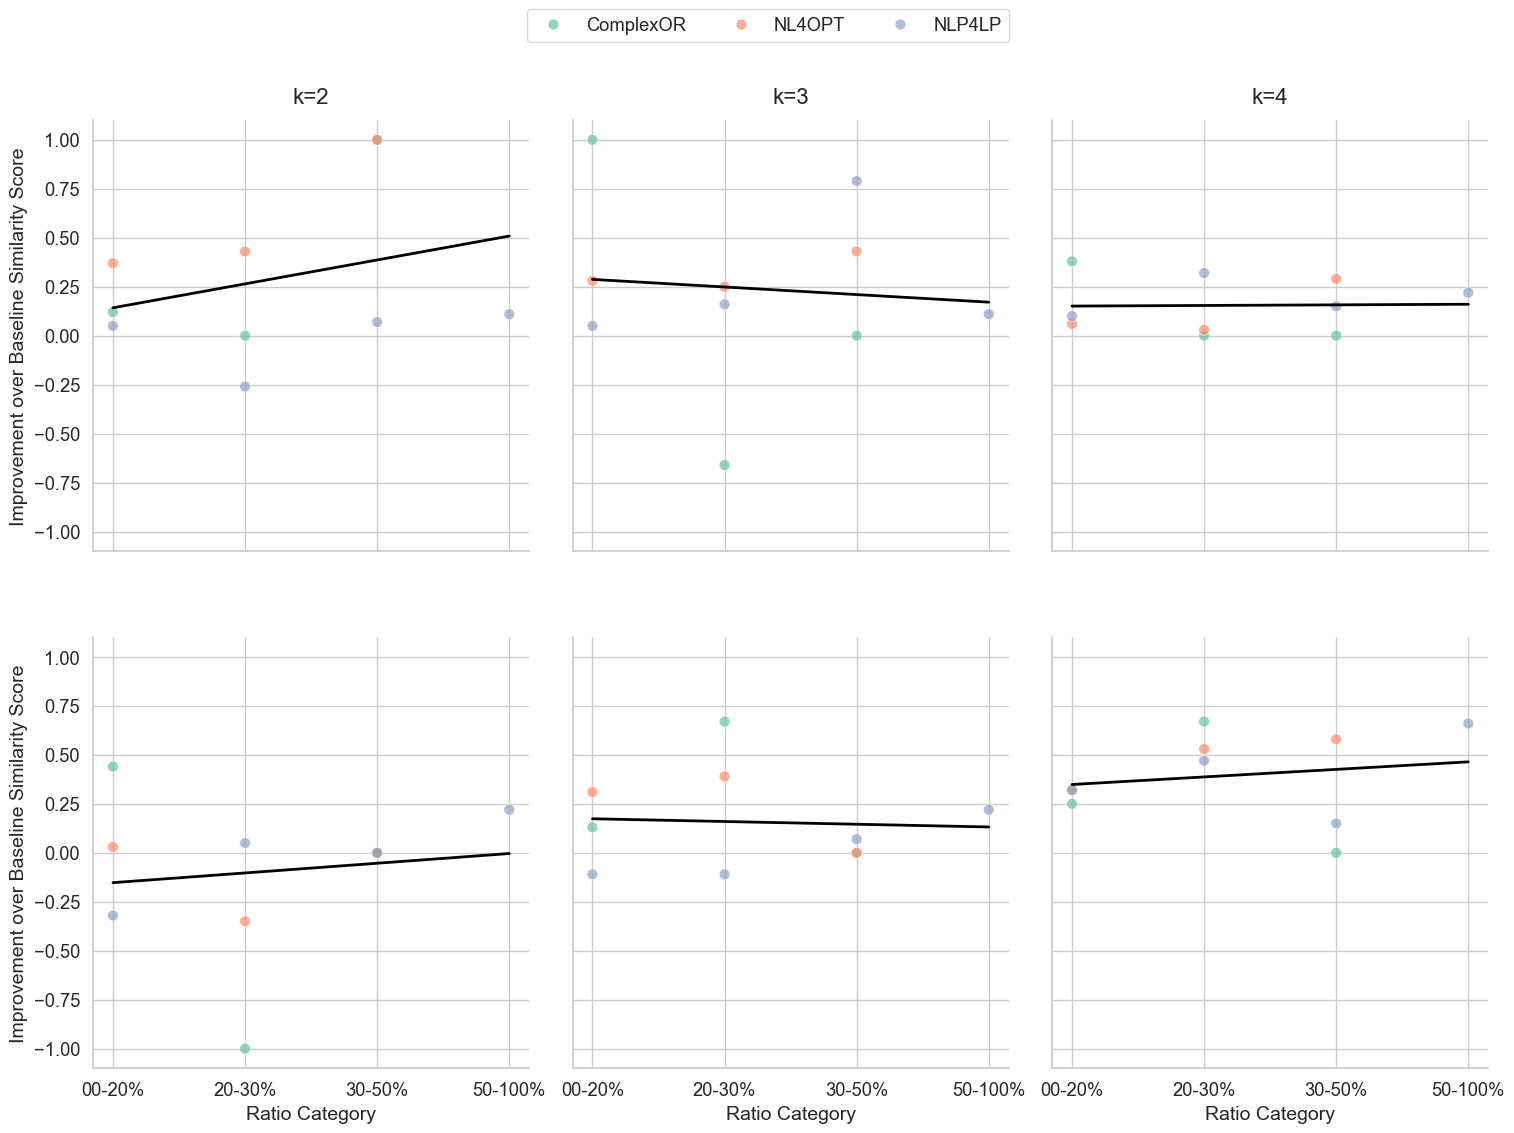

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data loading and preparation
reg_data_nlp4lp = pd.read_csv("reg_data_nlp4lp.csv", header=[0,1], index_col=[0,1])
reg_data_complexor = pd.read_csv("reg_data_complexor.csv", header=[0,1], index_col=[0,1])
reg_data_nl4opt = pd.read_csv("reg_data_nl4opt.csv", header=[0,1], index_col=[0,1])

data_combined = pd.concat([
    reg_data_nlp4lp.assign(dataset='NLP4LP'),
    reg_data_complexor.assign(dataset='ComplexOR'),
    reg_data_nl4opt.assign(dataset='NL4OPT')
])

data_combined = data_combined[data_combined.index.get_level_values('question_idx') != 0]
data_combined = data_combined.reset_index().rename(columns={"level_0":"ratio_category"})

temp = data_combined.set_index(['ratio_category', 'question_idx', 'dataset'])
temp = temp.stack(level=0)  
temp = temp.stack(level=0)  
long_df = temp.reset_index()
long_df.columns = ['ratio_category', 'question_idx', 'dataset', 'score_type', 'model_type', 'score']
long_df['score'] = pd.to_numeric(long_df['score'], errors='coerce')

ratio_map = {
    "00-20%": 1,
    "20-30%": 2,
    "30-50%": 3,
    "50-100%": 4
}
long_df['ratio_numeric'] = long_df['ratio_category'].map(ratio_map)

# Focus on Llama model
sub_df = long_df[long_df['model_type'].isin(["Prompting (llama3.1-8b)", "BiTextion (llama3.1-8b)"])]
pivot_df = sub_df.pivot_table(
    index=['ratio_category', 'question_idx', 'score_type', 'dataset', 'ratio_numeric'],
    columns='model_type',
    values='score'
).reset_index()

pivot_df = pivot_df.rename(columns={
    'BiTextion (llama3.1-8b)': 'score_bi', 
    'Prompting (llama3.1-8b)': 'score_b'
})
pivot_df = pivot_df.dropna(subset=['score_b', 'score_bi'])
pivot_df['y'] = pivot_df['score_bi'] - pivot_df['score_b']

def run_regression_difference(df, score_type):
    sub = df[df['score_type'] == score_type].copy()
    if len(sub) == 0:
        return sub, None
    model = smf.ols("y ~ ratio_numeric", data=sub).fit()
    return sub, model

# Only include c_score and o_score
score_types = ['c_score', 'o_score']
titles = {
    'c_score': 'Constraint Similarity',
    'o_score': 'Objective Similarity'
}

question_idxs = pivot_df['question_idx'].unique()
question_idxs = np.sort(question_idxs)  # ensure a sorted order if needed

sns.set_theme(style='whitegrid', font_scale=1.2)

# Create subplots:
# Rows = 2 (c_score in first row, o_score in second)
# Cols = number of question_idxs
fig, axs = plt.subplots(2, len(question_idxs), figsize=(6 * len(question_idxs), 12), sharey=True)

if len(question_idxs) == 1:
    axs = np.array([axs])  

for row_idx, s_type in enumerate(score_types):
    for col_idx, qid in enumerate(question_idxs):
        q_data = pivot_df[pivot_df['question_idx'] == qid]
        data_sub, model = run_regression_difference(q_data, s_type)
        
        ax = axs[row_idx][col_idx]
        if row_idx == 0 and col_idx == 0:
            legend_setting = 'full'
        else:
            legend_setting = False

        sns.scatterplot(
            x='ratio_numeric', y='y', hue='dataset',
            data=data_sub, alpha=0.7, ax=ax,
            s=60, edgecolor='white', linewidth=0.5,
            palette='Set2', legend=legend_setting
        )
        if model is not None:
            x_vals = np.linspace(data_sub['ratio_numeric'].min(), data_sub['ratio_numeric'].max(), 100)
            y_pred = model.predict(pd.DataFrame({'ratio_numeric': x_vals}))
            ax.plot(x_vals, y_pred, color='black', linewidth=2)
            
        if row_idx == 1:
            ax.set_xlabel('Ratio Category', fontsize=14)
            ax.set_xticks([1, 2, 3, 4])
            ax.set_xticklabels(['00-20%', '20-30%', '30-50%', '50-100%'])       
        else:
            ax.set_xlabel(None, fontsize=14)
            ax.set_title(f"k={qid+1}", fontsize=16, pad=12)
            ax.set_xticks([1, 2, 3, 4])
            ax.set_xticklabels(['', '', '', ''])       

        if col_idx == 0:
            ax.set_ylabel('Improvement over Baseline Similarity Score', fontsize=14)
        else:
            ax.set_ylabel('')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

handles, labels = axs[0][0].get_legend_handles_labels()
legend = axs[0][0].get_legend()
if legend is not None:
    legend.remove()
plt.subplots_adjust(wspace=0.1, hspace=0.2, top=0.90)
# global legend
fig.legend(handles, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 1))
plt.show()